## Cluster Analysis on NewGroups - NLP

Xuyang Ji <br> Feb 18st, 2023

In [1]:
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import importlib
# get rid of warning–>RuntimeWarning: divide by zero 
#encountered in true_divide in computing TF-IDF matrix 
#import warnings 
#warnings.filterwarnings("ignore")

%cd ~/Desktop/DSC478 ML/Assignment3/newsgroups5

/Users/xuyangji/Desktop/DSC478 ML/Assignment3/newsgroups5


### I. Data Preprocessing

The _**newsgroups5**_ contains 2,500 documents, represented as bags of its words across 9,328 terms, with each value represent raw term occurance counts. The bag-of-words structure in _**DocByTerm**_is used in _**K-Mean Cluster Analysis**_ Method of document classification, where the occurance of each word is used as a feature for training the classifier. The goal is to perform clustering on the documents and compare the clusters to the actual categories in the DocClass dataframe, detailed structure as follows:

- The term-by-document matrix is given in "matrix.txt", whose format is defined by rows and columns data where a newline terminates each row to begin the next row, and each column is separated by a comma within the row. The resulting tranposed _**DocByTerm**_ dataframe records 2,500 documents for rows, measured across 9,328 terms in each column.
   - _**DocTrain**_ : The term-document frequency matrix for the training set using random splitting methods, containing 2,000 documents.  
   - _**DocTest**_: The term-document frequency for the test set, containing 500 documents.


- The category labels for the documents are provided in the file "classes.txt", with each document belonging to one of 5 categories windows (0), crypt (1), christian (2), hockey (3), forsale (4). The resulting _**DocClass**_ dataframe contains 2,500 rows, each indicating the labels associated with each document. 
    - _**LabTrain**_: The file contains the labels associated with each of the 2,000 training document. 
    
    - _**LabTest**_: The file contains the labels associated with each of the 500 test document.
    

- The dictionary for the dataset is given in the file "terms.txt". the resulting _**Terms**_ dataframe contains 9328 rows, each line contains a term and corresponds to the corresponding rows in _DocByTerm_ frequency matrices. 

In [34]:
#Loading & Preprocessing Document*Term dataframe
TermByDoc=pd.read_csv("~/Desktop/DSC478 ML/Assignment3/newsgroups5/matrix.txt",header =None)
DocByTerm= TermByDoc.T

#Loading Terms & DocClass dataframe
Terms = pd.read_table("~/Desktop/DSC478 ML/Assignment3/newsgroups5/terms.txt", header = None)
DocClass = pd.read_csv("~/Desktop/DSC478 ML/Assignment3/newsgroups5/classes.txt",
                     header=None, delimiter=' ',dtype=str, skiprows=1, index_col=0)

#Splitting DocByTerm in 0.8:0.2 split ratio
#Use DocTrain & LabTrain for clustering model training
DocTrain, DocTest, LabTrain, LabTest = train_test_split(DocByTerm, DocClass, 
                                                        test_size=0.2,random_state=961)
#Reindex row 
DocTrain, LabTrain= DocTrain.reset_index(drop=True), LabTrain.reset_index(drop=True)
DocTrain.head(5)

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
LabTrain.T

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
1,4,1,0,2,4,1,1,0,3,4,...,0,3,0,0,1,3,2,2,4,4


#### I.a. Zipf Distribution in Training Data

By calculating the frequency that each word appears in the documents, _**ax**_ and _**max**_ are the top 2 most commonly presented words in the training dataset. The term frequency indicates that those two words are most significant within the overall document. As shown in the plot, the less frequent data are lumped together at the end of the frequency spectrum, where their frequency is not distinguishable and can mess up the classification algorithm. 

In [32]:
#Compute term frequencies across all documents in the training set 
#to get idea of term distributions across the corpus
termFreqs = DocTrain.sum(axis=0)
tf= pd.DataFrame({'Count': termFreqs.values})
tf= tf.join(Terms)
tf.sort_values(by="Count",ascending=False).T

,547,4982,7895,5795,9129,3345,4449,3266,417,9025,...,4539,3555,559,3154,1792,5863,7294,375,2339,7779
Count,35788,2576,2162,1535,1250,1092,944,937,890,889,...,0,0,0,0,0,0,0,0,0,0
0,ax,max,subject,on,write,god,know,get,articl,window,...,larmer,harper,babych,fuhrbash,creighton,otagoacnz,semak,arbitrarili,dougb,stastni


#### I.b. TF-IDF Transformation 

To deal with the Zipf distribution problem, _**Term Frequency*Inverse Document Frequency**_ is applied. The method weights terms highly if they are frequent in the trainng document but infrequent in the whole collection, while providing low values for common words in the collection. The _**IDF_train**_ contains weighted value of each searched term, presented as a multi-dimensional array, with a dimension defined by _**Term*Document**_. Each column corresponds to one of the document and each row corresponds to one term, and the (i,j) th element of the matrix shows the frequency of the ith term in the jth document. The final _**DT_tfidf**_ is computed with DocTrain.T multipled by (IDF: Terms*Docs)values for each document-term entry.

In [24]:
NDocs = DocTrain.shape[0] #2000
NTerms=DocTrain.shape[1] #9328
#Finding doc counts for each term, termFreqs(1,9328)
docFreqs= pd.DataFrame([(DocTrain!=0).sum(0)+1]).T #9328*1

#Creating a matrix with all entries=NDocs, NMatrix.shape is (9328,2000) 
NMatrix = np.ones(np.shape(DocTrain.T),dtype=float)*NDocs
np.set_printoptions(precision=2,suppress=True,linewidth=120)

#Doc frequency (df) for a term t is the number of docs in which t appears divided by total number of docs.
#IDF is the log of the inverse of document frequency, a function of the term, so all rows will be identical 
#IDF_train's shape(9328terms,2000doc).
IDF_train= np.log2(np.divide(NMatrix,np.array(docFreqs)))
print(IDF_train.all())

True


In [26]:
IDF_train

array([[7.64, 7.64, 7.64, ..., 7.64, 7.64, 7.64],
       [8.64, 8.64, 8.64, ..., 8.64, 8.64, 8.64],
       [6.64, 6.64, 6.64, ..., 6.64, 6.64, 6.64],
       ...,
       [8.97, 8.97, 8.97, ..., 8.97, 8.97, 8.97],
       [8.97, 8.97, 8.97, ..., 8.97, 8.97, 8.97],
       [8.64, 8.64, 8.64, ..., 8.64, 8.64, 8.64]])

In [29]:
#Computing DocTrain.T*(IDF: Terms*Docs)values for each document-term entry
TD_tfidf= DocTrain.T* IDF_train
#Shape of DT_tfidf is 2000 Docs × 9328 terms, no need to transpose when calling kMeans 
#to cluster the documents
pd.set_option("display.precision", 2)
DT_tfidf= np.array(TD_tfidf.T)
print(DT_tfidf.shape)
DT_tfidf

(2000, 9328)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
import os
import sys
import importlib
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import kMeans
importlib.reload(kMeans)
from sklearn.metrics import completeness_score, homogeneity_score

### II. Choosing K for Automatic Document Clustering 

#### II.a kMeans Function Modification 

- Since randCent() creates a set of k random centroids by finding the minimum and maximum values of each dimension in specific dataset,  _**random.seed(961)**_ has been added to the _**randCent**_function to reproduce the randomly chosen centroids for analysis. 


- _**cosineDist**_ function is added to the local module to calculate Cosine similarity, as follows:
```
def cosineDist(vecA,vecB):
    normA= np.array([np.linalg.norm(vecA)])
    normB= np.array([np.linalg.norm(vecB)])
    #Compute Cosine Similarity sim(D,x) with function call 
    sim= np.dot(vecA,vecB)/(normA*normB)   
    dist=1-sim
    return dist    
```
- In _**biKMEans**_ function, centroid0 = mean(dataSet, axis=0).tolist()[0] has been changed to _**centroid0 = mean(dataSet, axis=0).tolist()**_ to create one centroid with 9328 term characteristics, while avoiding _**ValueError: shapes (1,1) and (9328,) not aligned: 1 (dim 1) != 9328 (dim 0)**_

In [31]:
#Test run randcent function 
kMeans.randCent(DT_tfidf,4)

array([[ 21.02,   3.96, 143.14, ...,  32.88,  16.44,  19.81],
       [  0.64,   0.12,   4.35, ...,   1.  ,   0.5 ,   0.6 ],
       [ 43.93,   8.28, 299.1 , ...,  68.7 ,  34.35,  41.4 ],
       [ 16.72,   3.15, 113.85, ...,  26.15,  13.08,  15.76]])

In [33]:
kMeans.cosineDist(DT_tfidf[4],DT_tfidf[20])

array([0.99])

In [45]:
kMeans.biKmeans(DT_tfidf,1,kMeans.cosineDist)

(matrix([[0.06, 0.02, 0.26, ..., 0.05, 0.03, 0.06]]),
 matrix([[0.  , 0.99],
         [0.  , 0.98],
         [0.  , 0.98],
         ...,
         [0.  , 0.95],
         [0.  , 0.97],
         [0.  , 0.99]]))

#### II.b Measure Quality of Clustering by V-Measurements with kMeans & biKmeansFunction 

Since the _**LabTrain**_ contains the ground truth labels of the datapoints in _**DF_tfidf**_, extrinsic methods like homogeneity and completeness scores are used to measure clustering model quality.The _**completeness score**_ indicates whether all data-points belonging to the same class are clustered into the same cluster. Meantime, _**homogenity score**_ measures whether each cluster has data-points belonging to the same class label. In addition, Silhouette values for each instance in the data is used to measure of how similar an object is to its own cluster compared to other clusters. While it ranges from −1 to +1, where a high value closd to 1 indicates that the object is well matched to its own cluster and well separated from other clusters. 

Looking at the _**Quality**_ dictionary, given the ground truth, homogenity and completeness scores are the highest with 6 or more clusters. However, the average of silhouette score across all sample is the highest with 4 clusters. 

In [46]:
Quality={}
classLab= np.array(LabTrain).flatten()

for i in range(4,9):
    centroids, clusters = kMeans.kMeans(DT_tfidf,i,kMeans.cosineDist,kMeans.randCent)
    newC = clusters[:,0].astype(int)    
    clusterLab = np.unique(newC)
    NCluster = clusterLab.shape[0]
    silhouette_vals = metrics.silhouette_samples(DT_tfidf, newC, 
                                                 metric='euclidean')
    silhouette_avg = np.mean(silhouette_vals)    
    completeness= completeness_score(classLab,newC)
    homogeneity= homogeneity_score(classLab,newC)

    key=['completeness','homogenity',"silhouette_avg"]
    values=[round(completeness,3),round(homogeneity,3),round(silhouette_avg,3)]
    innerDic={}
    for p in range(len(key)):
        innerDic[key[p]]= values[p]
    Quality[i]= innerDic

Quality

{4: {'completeness': 0.755, 'homogenity': 0.329, 'silhouette_avg': -0.021},
 5: {'completeness': 0.802, 'homogenity': 0.543, 'silhouette_avg': -0.055},
 6: {'completeness': 0.827, 'homogenity': 0.696, 'silhouette_avg': -0.126},
 7: {'completeness': 0.827, 'homogenity': 0.696, 'silhouette_avg': -0.126},
 8: {'completeness': 0.826, 'homogenity': 0.696, 'silhouette_avg': -0.126}}

To overcome the problem of poor clusters when kMeans getting caught in a local minimum,bisecting KMeans starts out with one cluster and then splits the cluster in two. It then chooses a cluster to split decided by minimizing the SSE. Generally, biKmeans performs worse than kMeans interms of completeness, whereas less memebers of a given class are assigned to the same cluster than kMeans. Looking at the plot of the homogeneity, completeness, and silhouette score across different values of clusters, all models indicates the _**ideal value of k should be 5**_ with best maximum across three metrics. 

In [47]:
BiKmeanQuality={}

for i in range(4,9):
    cenList, cluster = kMeans.biKmeans(DT_tfidf,i,kMeans.cosineDist)
    newLab = np.array(cluster[:,0].astype(int)).flatten() 
    
    clusterBi = np.unique(newC)
    NClusterBi = clusterBi.shape[0]
    silhouette_bi = metrics.silhouette_samples(DT_tfidf, newLab, 
                                                 metric='euclidean')
    silhouette_bi = np.mean(silhouette_bi)
    completenessBi= completeness_score(classLab,np.ravel(newLab))
    homogeneityBi= homogeneity_score(classLab,np.ravel(newLab))
    keyBi=['completeness','homogenity','silhouette']
    valuesBi=[round(completenessBi,3),round(homogeneityBi,3),round(silhouette_bi,3)]
    Dic={}
    for p in range(len(keyBi)):
        Dic[keyBi[p]]= valuesBi[p]
    BiKmeanQuality[i]= Dic

BiKmeanQuality

{4: {'completeness': 0.716, 'homogenity': 0.279, 'silhouette': 0.131},
 5: {'completeness': 0.743, 'homogenity': 0.538, 'silhouette': -0.042},
 6: {'completeness': 0.776, 'homogenity': 0.691, 'silhouette': -0.041},
 7: {'completeness': 0.743, 'homogenity': 0.783, 'silhouette': -0.094},
 8: {'completeness': 0.692, 'homogenity': 0.785, 'silhouette': -0.113}}

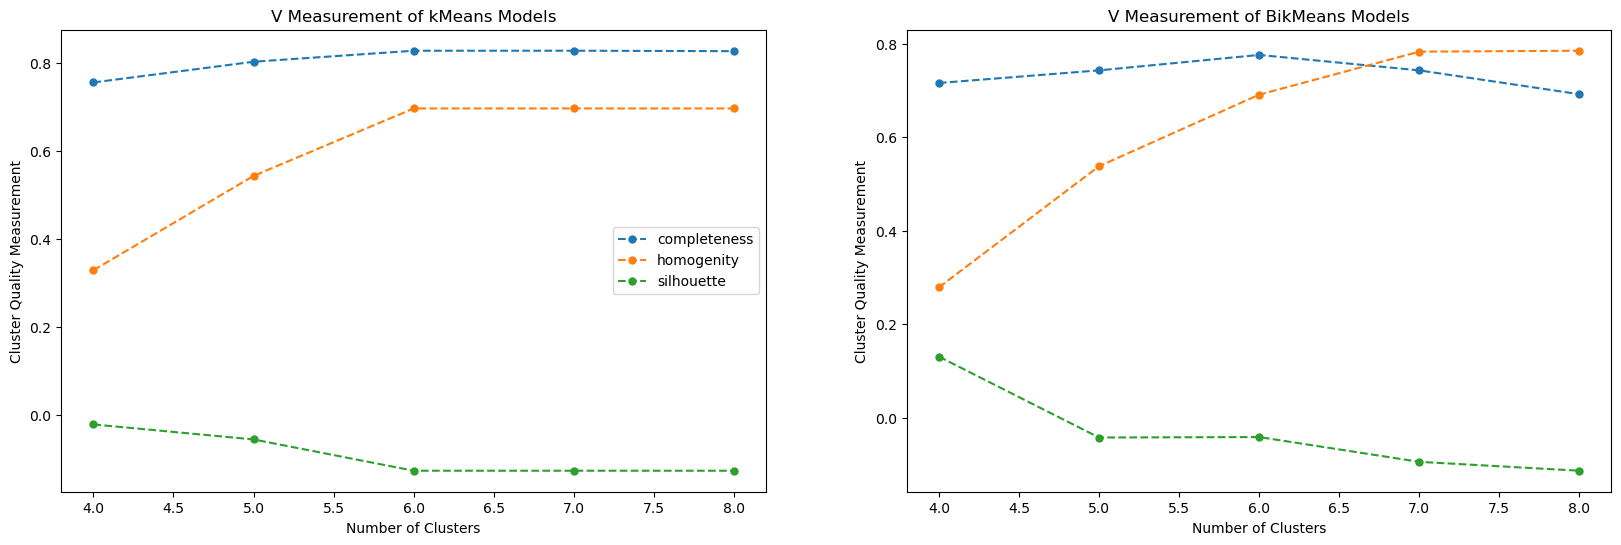

In [48]:
QualityDic= (pd.DataFrame.from_dict(Quality)).T
BiQualityDic= (pd.DataFrame.from_dict(BiKmeanQuality)).T

%matplotlib inline
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(QualityDic, markersize=5,marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Quality Measurement')
plt.title('V Measurement of kMeans Models')
plt.legend(['completeness','homogenity','silhouette'])

plt.subplot(1,2,2)
plt.plot(BiQualityDic, markersize=5,marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Cluster Quality Measurement')
plt.title('V Measurement of BikMeans Models')
plt.show()

#### II.c Measure Quality of Clustering by SSE Elbow Methods with skLearn kMeans

The following SSE method gives an idea on what an appropriate number of clusters would be based on the sum of squared distance between data points and their assigned clusters’ centroids. The plot illustrates the line that helps in choosing the elbow point. It can be observed that the sum of squared errors (inertia) does not improve much after point K = 5. Hence, _**5 is chosen to be the number of clusters and each document is assigned to one of the clusters using the K-Means algorithm**_. This value of K matches the number of topics that are there after clubbing i.e. 5.

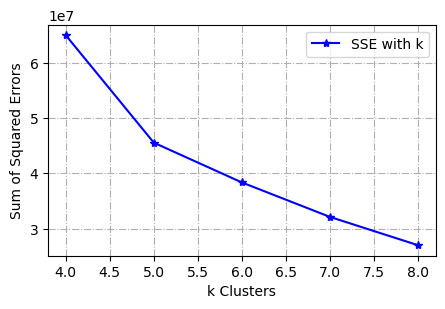

In [53]:
SSE = []  
for k in range(4, 9):
    estimator = KMeans(n_clusters=k,max_iter=300,n_init=10,
                      random_state=961)  
    estimator= estimator.fit(DT_tfidf)
    SSE.append(estimator.inertia_)
axis_X = range(4, 9)
%matplotlib inline
plt.figure(figsize=(5,3))
plt.xlabel('k Clusters')
plt.ylabel('Sum of Squared Errors')
plt.plot(axis_X, SSE, '*-', label='SSE with k', color='blue')
plt.legend()
plt.grid(linestyle='-.')
plt.show()

### III. Implementing Automatic Document Clustering with K=5

#### III.a Using PCA as DImension Reduction Methods with sklearn K-means 

In [63]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=5)
DTtrans = pca.fit(DocTrain).transform(DocTrain)

In [64]:
pca.explained_variance_ratio_

array([1., 0., 0., 0., 0.])

#### III.b  Using SVD as Dimension Reduction Method with sklearn K-means

In [54]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# While DT_tfidf results are normalized, LSA/SVD results are not, redo the normalization
svd = TruncatedSVD(n_components=2,n_iter=100,
                                 random_state=961)
# DTM_tfidf results are normalized, redo the normalization since LSA/SVD results are not normalized. 
normalizer = Normalizer(copy=False)
LSA = make_pipeline(svd, normalizer)

X= LSA.fit_transform(DT_tfidf) #shape(2000,20)

In [57]:
svd.explained_variance_ratio_

array([1., 0.])

In [ ]:
kms=KMeans(n_clusters=5,max_iter=300,n_init=10,random_state=961).fit(X)
clusters= kms.labels_
kCenter=kms.cluster_centers_
original_centroids = svd.inverse_transform(kCenter)
#argsort returns the indices, sort cluster centers by closeness to the centroid 
sorted_centroids = original_centroids.argsort()[:, ::-1] 

Terms=np.array(Terms).flatten()
LSA_topics = {}
for c in range(5):
    topic = ','.join([Terms[i] for i in [p for p in sorted_centroids[c, :5]]])
    LSA_topics[c] = topic
    print("Cluster %i: " % c + topic)

In [ ]:
unique= np.unique(clusters)
for i in unique:
    plt.scatter(X[clusters == i , 0] , X[clusters == i , 1] , label = i)
plt.scatter(kCenter[:,0], kCenter[:,1], marker="x", color='k')
#This is done to find the centroid for each clusters.
plt.legend()
plt.show()

#### III.c Using Straightforward kMeans.kMeans Function

In [105]:
centroid5, cluster5 = kMeans.kMeans(DT_tfidf, 5, kMeans.cosineDist, kMeans.randCent)
pd.options.display.float_format='{:,.2f}'.format
centroid5 = pd.DataFrame(centroid5, columns=Terms)
#clusters' first column for the index of the cluster, the second column is to store the error,which is the 
#distance from the cluster centroid to the current point. 
doc_clusters = pd.DataFrame(cluster5, columns=["Cluster", "MinDistance**2"])
doc_clusters.T

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
Cluster,3.00,1.00,3.00,1.00,3.00,1.00,1.00,3.00,0.00,3.00,...,3.00,0.00,3.00,3.00,1.00,0.00,1.00,1.00,4.00,3.00
MinDistance**2,0.89,0.77,0.67,0.38,0.84,0.81,0.85,0.72,0.57,0.61,...,0.66,0.49,0.86,0.47,0.72,0.90,0.57,0.53,0.59,0.79


In [189]:
centroid5

,aa,aargh,aaron,aaronc,ab,abandon,abc,abid,abil,abl,...,zq,zr,zrb,zs,zu,zubov,zv,zw,zx,zz
0,0.00,0.08,0.02,0.00,0.00,0.00,0.71,0.00,0.09,0.31,...,0.00,0.00,0.00,0.00,0.00,0.14,0.00,0.00,0.00,0.00
1,0.10,0.00,0.58,0.11,0.20,0.03,0.01,0.05,0.31,0.45,...,0.13,0.16,0.05,0.06,0.08,0.00,0.53,0.11,0.07,0.16
2,0.00,0.00,0.00,0.00,1.23,0.00,0.00,0.00,0.00,0.00,...,0.00,1.40,0.00,16.76,0.00,0.00,0.00,1.49,0.00,0.00
3,0.05,0.00,0.06,0.00,0.05,0.02,0.02,0.00,0.05,0.25,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


As the ground truth category labels for the documents are provided, the top 5 terms in centroid for each cluster are evaluated against the theme of categories. The first cluster with top terms including game, team, hockei, corresponds to _**class hockey, which labeled as 3**_. The second cluster with top terms including god, christian, peopl and others, corresponds to _**class christian labeled as 2**_. Similarly, the fifth cluster corresponds to _**class crypt labeled as 1**_. 

Worth noting, the third cluster with top terms includng max,bxn, and so on, is obscure in terms of meaning. Meantime,the fourth cluster contains top terms including _**window and sale**_, which corresponds to different classes,  _**class forsale labeled as 4 and class window labeled as 0**_. Hence, datapoints in cluster 3 and 4 does not belong to the same class, meantime, they are different from the ground truth label. 

In [148]:
Top5 =pd.DataFrame(
    centroid5.apply(lambda x:list(centroid5.columns[np.array(x).argsort()[::-1][:5]]),axis=1).to_list(),  
    columns=['Top1', 'Top2', 'Top3',"Top4",'Top5'])
Top5

,Top1,Top2,Top3,Top4,Top5
0,game,team,plai,player,hockei
1,god,cx,christian,kei,peopl
2,ax,max,pl,giz,bxn
3,window,file,do,driver,sale
4,db,bh,cs,si,byte


As the value of the silhouette coefﬁcient is between [-1, 1], and ascore of 1 denotes the best meaning that the datapoint is very compact within the cluster to which it belongs and far away from the other clusters. Looking at the plot, there are multiple cluster near a value of 0, which _**denote overlapping clusters in the current model**_. Meantime,the second cluster has the largest size comparing to others.  

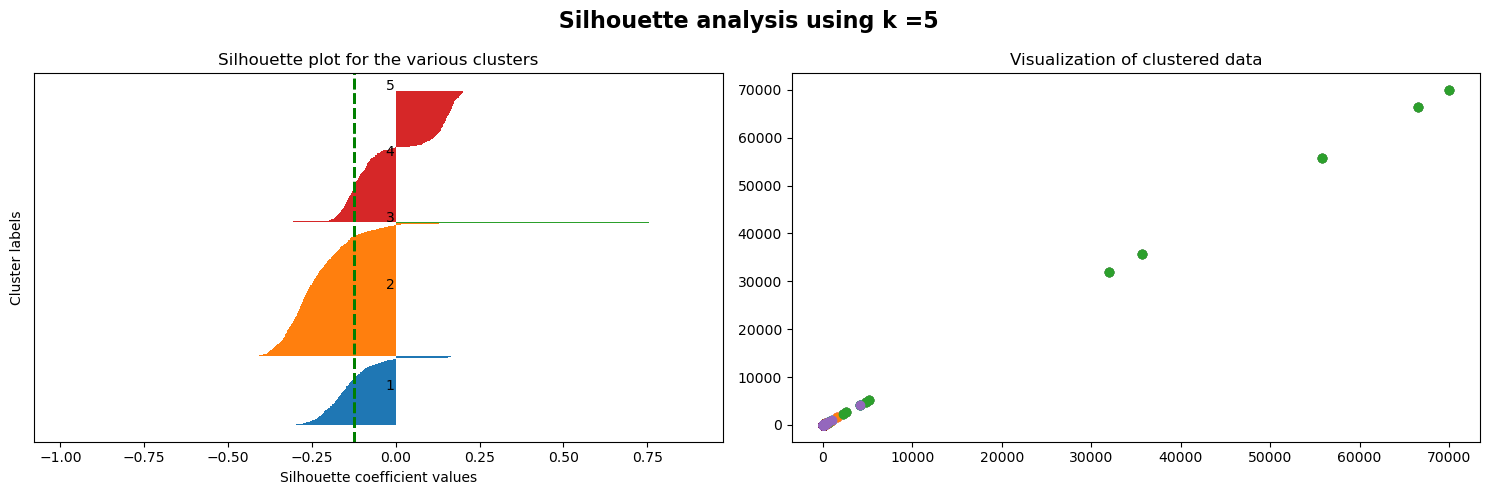

In [127]:
y_ticks = []
y_lower = y_upper = 0
y_predict= cluster5[:,0]
fig, ax = plt.subplots(1,2,figsize=(15,5))
for i,cluster in enumerate(np.unique(y_predict)):
    cluster_silhouette_vals = silhouette_vals[y_predict ==cluster]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    
    ax[0].barh(range(y_lower,y_upper),cluster_silhouette_vals,height =1);
    ax[0].text(-0.03,(y_lower+y_upper)/2,str(i+1))
    y_lower += len(cluster_silhouette_vals)
    
    # average silhouette score 
    avg_score = np.mean(silhouette_vals)
    ax[0].axvline(avg_score,linestyle ='--',linewidth =2,color = 'green')
    ax[0].set_yticks([])
    ax[0].set_xlabel('Silhouette coefficient values')
    ax[0].set_ylabel('Cluster labels')
    ax[0].set_title('Silhouette plot for the various clusters');
    
    
    # scatter plot of data colored with labels
    for i in np.unique(y_predict):
        ax[1].scatter(DT_tfidf[y_predict == i ] ,
                      DT_tfidf[y_predict == i ] , label = i)
    ax[1].set_title('Visualization of clustered data', y=1)  
    plt.tight_layout()
    plt.suptitle(f' Silhouette analysis using k =5',fontsize=16,fontweight = 'semibold')

#### III.d Cluster Model Evaluation 

In [264]:
from wordcloud import WordCloud

def wordcloud(data,title):
    wordcloud=WordCloud(background_color='white', max_font_size=40,
                       scale=3,random_state=1,colormap='Set2').generate_from_frequencies(data)
    fig=plt.figure(1,figsize=(12,12))
    plt.axis('off')
    if title:
        fig.suptitle(title,fontsize=10)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

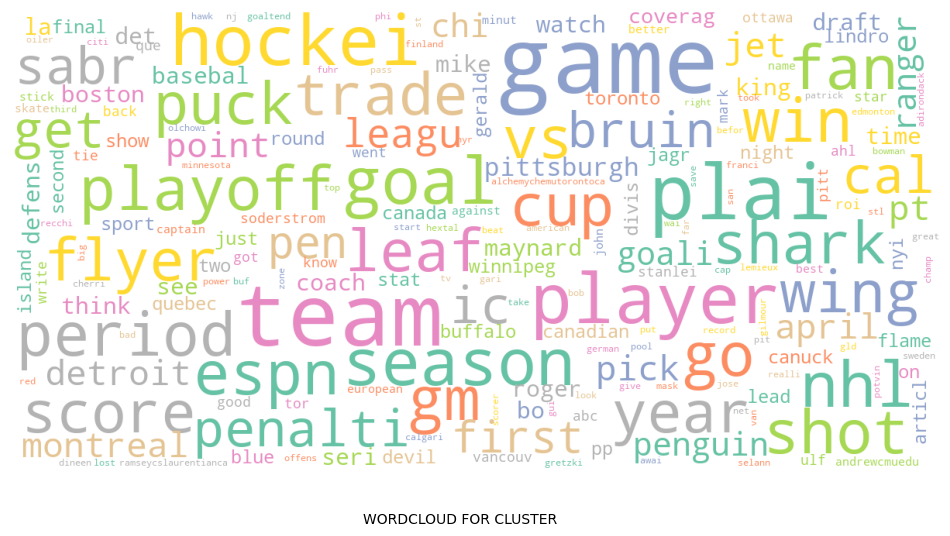

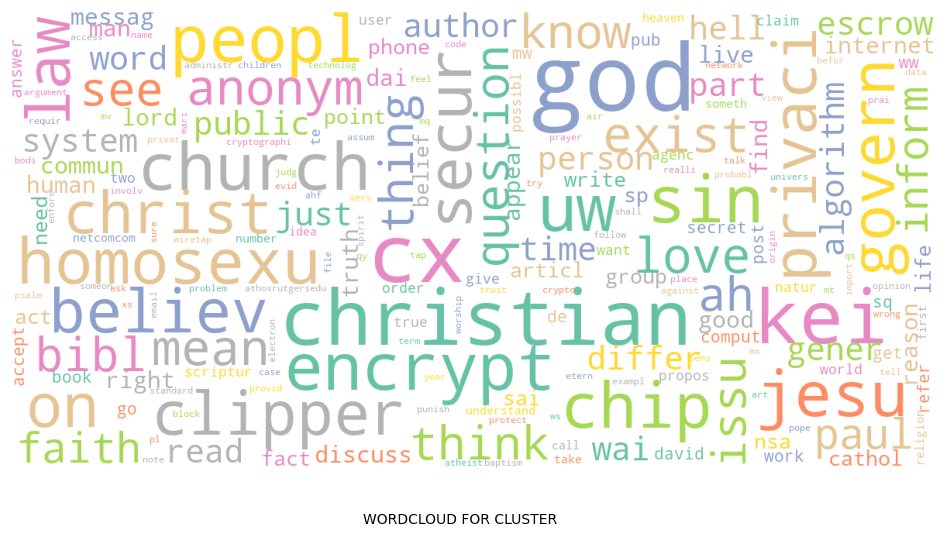

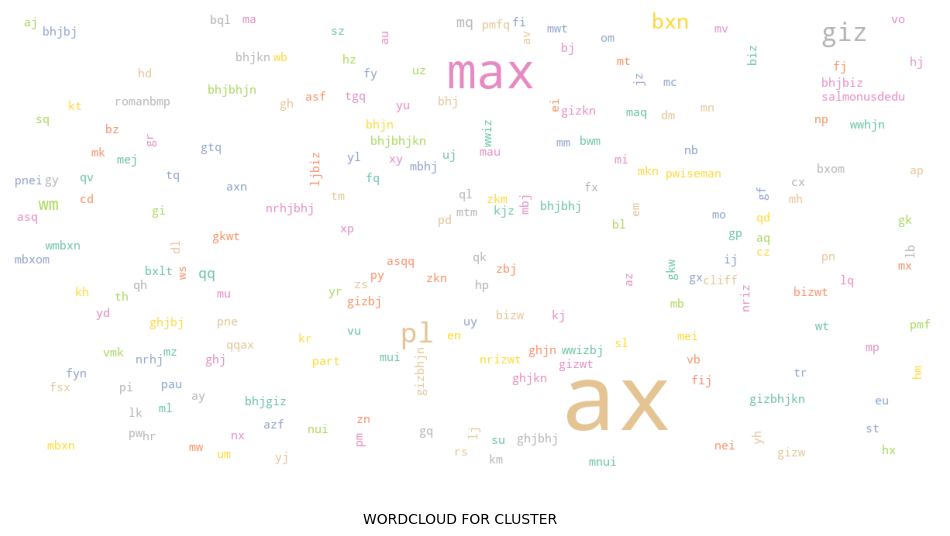

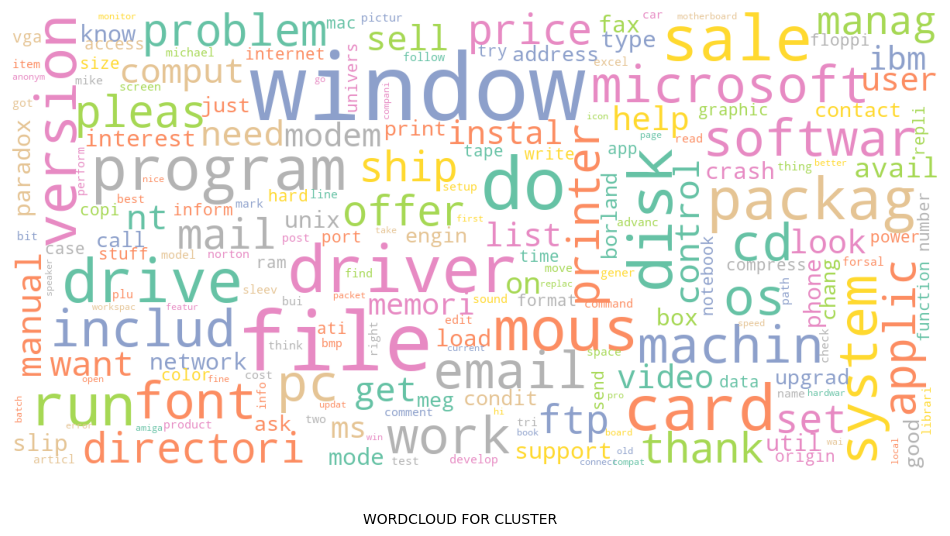

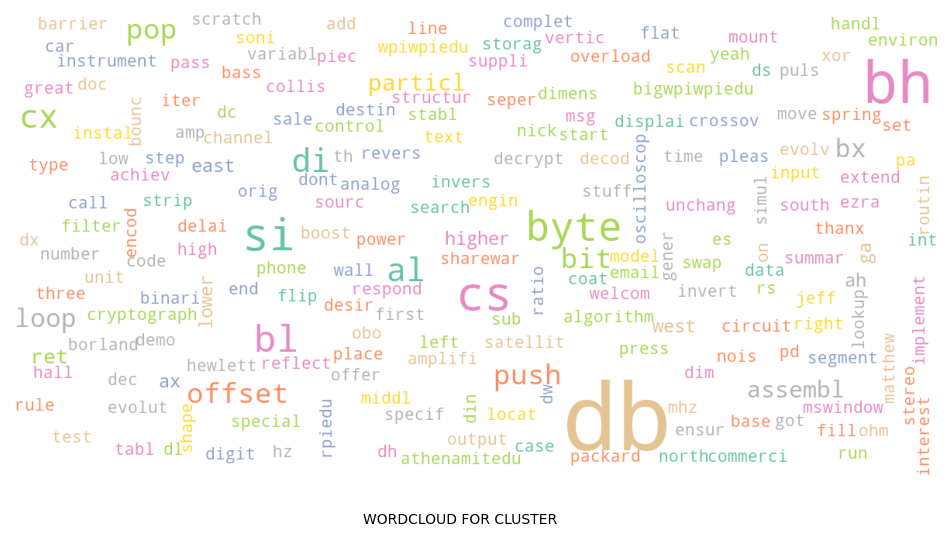

In [265]:
for row_dict in centroid5.to_dict('records'):
    wordcloud(row_dict, "WORDCLOUD FOR CLUSTER")

In [176]:
def cluster_report(clusters, centroids, termFreq, terms):
    """the function expects clusters and centroids output from the kMeans.py
    function, termFreq is the document frequency for each time. The function 
    returns two dictionaries, one with top N terms in each cluster sorted by the
    cluster DF values and related statistics, and the other contains the size of the clusters. """
    Cluster={}
    #weight is TFxIDF weights of for each of the terms 
    weight= pd.DataFrame(IDF_train.T[0],index=(np.array(Terms).flatten()))
    #TopTerm is the dataframe contains top10 terms for each cluster 
    TopTerm =pd.DataFrame(centroid5.apply(lambda x:list(centroid5.columns[np.array(x).argsort()[::-1][:10]]),axis=1).to_list())
    #tfDreq is the dataframe with term as the index and doc frequency as values                   
    tdFreq= termFreq.set_index(0)
    cluster_labels = np.unique(clusters[:,0])
    n_clusters = cluster_labels.shape[0]    
    
    for i,r in TopTerm.iterrows():
        ClusterDict= pd.DataFrame({'Freq' :[],'DF':[],'% of Doc':[]})
        for vocab in r.values:
            freq= float(weight.loc[[vocab]].values)
            df= int(tdFreq.loc[[vocab]].values)
            percent= float(df/NDocs)*100
            ClusterDict.loc[vocab]=np.asarray([freq,df,percent],dtype=object)
        Cluster[i]= ClusterDict
    
    #return the size of clusters
    size = {}
    for c in cluster_labels:
        size[c] = len(DT_tfidf[clusters[:,0] == c])

    return size, Cluster 

In [180]:
def display_clusters(clusterDict, clusterSize):
    for c in clusterDict.keys():
        cluster_rep = clusterDict[c]
        print("\nCluster ", c, "size =", clusterSize[c])
        print("----------------------------------------------")
        print(cluster_rep.sort_values(by="Freq", ascending=False))
    return

In [181]:
size, Cluster= cluster_report(cluster5, centroid5,tf,Terms)
display_clusters(Cluster, size)


Cluster  0 size = 414
----------------------------------------------
       Freq   DF % of Doc
gm     6.32  148     7.40
season 4.49  196     9.80
goal   4.41  223    11.15
nhl    4.31  185     9.25
fan    4.17  187     9.35
player 3.89  294    14.70
hockei 3.64  290    14.50
team   3.40  491    24.55
plai   3.30  449    22.45
game   2.87  771    38.55

Cluster  1 size = 793
----------------------------------------------
          Freq    DF % of Doc
cx        7.80   368    18.40
uw        7.64   202    10.10
sin       4.49   348    17.40
church    4.20   365    18.25
jesu      4.10   354    17.70
encrypt   3.49   460    23.00
christian 3.32   662    33.10
kei       3.09   729    36.45
god       3.02  1092    54.60
peopl     2.25   874    43.70

Cluster  2 size = 6
----------------------------------------------
    Freq     DF % of Doc
bxn 8.38    109     5.45
giz 8.16    206    10.30
ql  7.97     62     3.10
qq  7.80     69     3.45
max 7.38   2576   128.80
ax  7.27  35788 1,789.40
m

### IV. Classifying Test Data with kMeans Model 

Finally, using the cluster assignments in the centroid dataframe as class labels, each of the documents in the 20% set-aside data is categorized into each of the appropriate cluster based on Cosine similarity between each test document and cluster centroids. 

#### IV.I Data Preprocessing 

In [269]:
NDocsTest = DocTest.shape[0] #500
NTermsTest=DocTest.shape[1] #9328
#Finding doc counts for each term, termFreqsTest(1,9328)
docFreqsTest= pd.DataFrame([(DocTest!=0).sum(0)+1]).T #9328*1

#Creating a matrix with all entries=NDocsTest, NMatrixT.shape is (9328,500) 
NMatrixT = np.ones(np.shape(DocTest.T),dtype=float)*NDocsTest
np.set_printoptions(precision=2,suppress=True,linewidth=120)

#Doc frequency (df) for a term t is the number of docs in which t appears divided by total number of docs.
#IDF is the log of the inverse of document frequency, a function of the term, so all rows will be identical 
#IDF_test's shape(9328terms,500doc).
IDF_test= np.log2(np.divide(NMatrixT,np.array(docFreqsTest)))
print(IDF_test.all())

True


In [270]:
#Computing DocTest.T*(IDF: Terms*Docs)values for each document-term entry
Test_tfidf= DocTest.T* IDF_test
#Shape of Test_tfidf is 500 Docs × 9328 terms, no need to transpose when calling kMeans 
#to cluster the documents
pd.set_option("display.precision", 2)
DT_test= np.array(Test_tfidf.T)
print(DT_test.shape)
DT_test

(500, 9328)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### IV.II Data Classifying 

In [278]:
def cosineDist(vecA,vecB):
    normA= np.array([np.linalg.norm(vecA)])
    normB= np.array([np.linalg.norm(vecB)])
    #Compute Cosine Similarity sim(D,x) with function call 
    sim= np.dot(vecA,vecB)/(normA*normB)   
    dist=1-sim
    return dist 

In [279]:
def kMeansTest(dataSet, k, distMeas=cosineDist, cent=centroid):
    m = shape(dataSet)[0] #number of items in the dataset
    clusterAssment = mat(zeros((m,2))) #initial cluster assignment matrix

    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = inf; minIndex = -1
            #Finding the closet centroid 
            for j in range(k):
                #calculating distance with distMeas function 
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: 
                clusterChanged = True
            
            clusterAssment[i,:] = minIndex,minDist**2
    return clusterAssment

In [288]:
clusterAss=kMeansTest(DT_test,5,cosineDist,centroid5)
test_clusters = pd.DataFrame(clusterAss, columns=["Cluster", "MinDistance**2"])
test_clusters.T

/var/folders/hn/1qw06vh159b5q65fm9_03ycm0000gn/T/ipykernel_3275/3163418187.py:19: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  clusterAssment[i,:] = minIndex,minDist**2


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
Cluster,3.00,3.00,3.00,1.00,1.00,3.00,0.00,1.00,1.00,1.00,...,0.00,1.00,0.00,1.00,0.00,3.00,0.00,1.00,3.00,2.00
MinDistance**2,0.62,0.84,0.57,0.86,0.76,0.79,0.87,0.77,0.79,0.76,...,0.96,0.85,0.89,0.92,0.78,0.85,0.72,0.72,0.59,0.91


In [287]:
testLab= np.array(LabTest).flatten()
pTest = test_clusters["Cluster"].astype(int)    
pCluster = np.unique(pTest)
PCluster = pCluster.shape[0]

silhouette_test = metrics.silhouette_samples(DT_test, pTest,metric='euclidean')
silhouette_test = np.mean(silhouette_test)    
    
completeness_test= completeness_score(testLab,pTest)
homogeneity_test= homogeneity_score(testLab,pTest)

print("\nSilhouette Score",silhouette_test , "\nCompleteness", completeness_test,"\nHomogeneity", homogeneity_test)



Silhouette Score -0.08310750045410663 
Completeness 0.6606631382848428 
Homogeneity 0.43224327508904165
